# P2

## get the data:

In [30]:
# Load necessary library
library(quantmod)

# Set seed for reproducibility
set.seed(53600945)

# Generate 100 random integers within the range 1 to 377
random_indices <- sample(1:377, 100, replace = FALSE)

# Read the tickers from the "symbols2.csv" file
symbols_df <- read.csv("symbols2.csv", sep = ",", header = TRUE)

#print(symbols_df)

#print(random_indices)


# Select tickers based on the generated random integers
selected_tickers <- symbols_df$Symbol[random_indices]


print(selected_tickers)
# Define the start and end dates for the data download
start_date <- as.Date("2020-01-01")
end_date <- as.Date("2022-10-31")

# Initialize a list to store the stock data
stock_data_list <- list()

# Loop through the selected tickers and download the stock price data
for(ticker in selected_tickers) {
  # The tryCatch function is used to ignore errors (e.g., if the stock is not available)
  stock_data <- tryCatch({
    getSymbols(ticker, src = 'yahoo', from = start_date, to = end_date, auto.assign = FALSE)
  }, error = function(e) NULL)
  
  # If stock data was successfully downloaded, add it to the list
  if (!is.null(stock_data)) {
    stock_data_list[[ticker]] <- stock_data
  }
}

#print(head(stock_data_list))
# At this point, `stock_data_list` contains the downloaded stock data for each available ticker
# You can access each stock's data using stock_data_list[['Ticker']]


  [1] GILD KSS  ABC  BA   AEE  TRV  PCG  AN   BMC  RL   CL   AZO  TXN  MSFT HES 
 [16] NRG  CAH  IP   ETR  FITB HAS  IRM  TEL  PDCO SCHW CVS  IFF  COF  SE   IR  
 [31] FE   JPM  PNC  NFLX XRX  WMB  CVX  FTI  FISV V    NEE  PHM  NOV  KO   PBCT
 [46] MO   GCI  LRCX BSX  PG   MMM  RSG  HSY  EFX  ROST EXPD PLD  FDX  HOG  BBBY
 [61] DRI  HST  INTU AEP  GIS  BK   ADBE TAP  MNST BIIB PGR  PSA  IGT  CHRW ICE 
 [76] VZ   MAS  HAL  DVN  PKI  BAC  VRSN BAX  EBAY SLM  PSX  PXD  CMI  A    CMS 
 [91] YUM  WEC  LLL  T    AXP  MDT  MCK  EA   WDC  PRU 
377 Levels: A AA AAPL ABC ABT ACE ACN ADBE ADI ADM ADP ADSK AEE AEP AES ... ZION


Warning message:
"BMC contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."

## compute log returns:

In [32]:
# Function to compute logarithmic returns
compute_log_returns <- function(stock_prices) {
  # Compute logarithmic returns using diff and log
  log_returns <- diff(log(Cl(stock_prices)))
  return(log_returns)
}

# Initialize a list to store the logarithmic returns for each stock
log_returns_list <- list()

# Loop through each stock's data in `stock_data_list` to compute the logarithmic returns
for(ticker in names(stock_data_list)) {
  stock_prices <- stock_data_list[[ticker]]
  log_returns <- compute_log_returns(stock_prices)
  log_returns_list[[ticker]] <- log_returns
}

#print(log_returns_list)
# At this point, `log_returns_list` contains the logarithmic returns for each available ticker
# You can access the logarithmic returns of each stock using log_returns_list[['Ticker']]


## compute mean log returns:

In [35]:
# Assuming `log_returns_list` contains the logarithmic returns for each stock

# Combine all logarithmic returns into a single data frame
# Each column in this data frame will represent a stock, and each row represents a date
combined_log_returns <- do.call(merge, c(log_returns_list, all = TRUE))

# Compute the mean logarithmic return for each date
mean_log_returns <- rowMeans(combined_log_returns, na.rm = TRUE)

# Convert the mean logarithmic returns to a data frame for easier handling
mean_log_returns_df <- data.frame(Date = index(combined_log_returns), MeanLogReturn = mean_log_returns)

# Preview the data frame containing the mean logarithmic returns
head(mean_log_returns_df)


Date,MeanLogReturn
2020-01-02,NaN
2020-01-03,-0.0044412149
2020-01-06,0.0009751706
2020-01-07,-0.0020736699
2020-01-08,0.0021340075
2020-01-09,0.0025843230


# ARMA:

In [49]:
# Assuming mean_log_returns_df is a vector. If it's a data frame, you may need to adjust this.
clean_data <- na.omit(mean_log_returns_df)


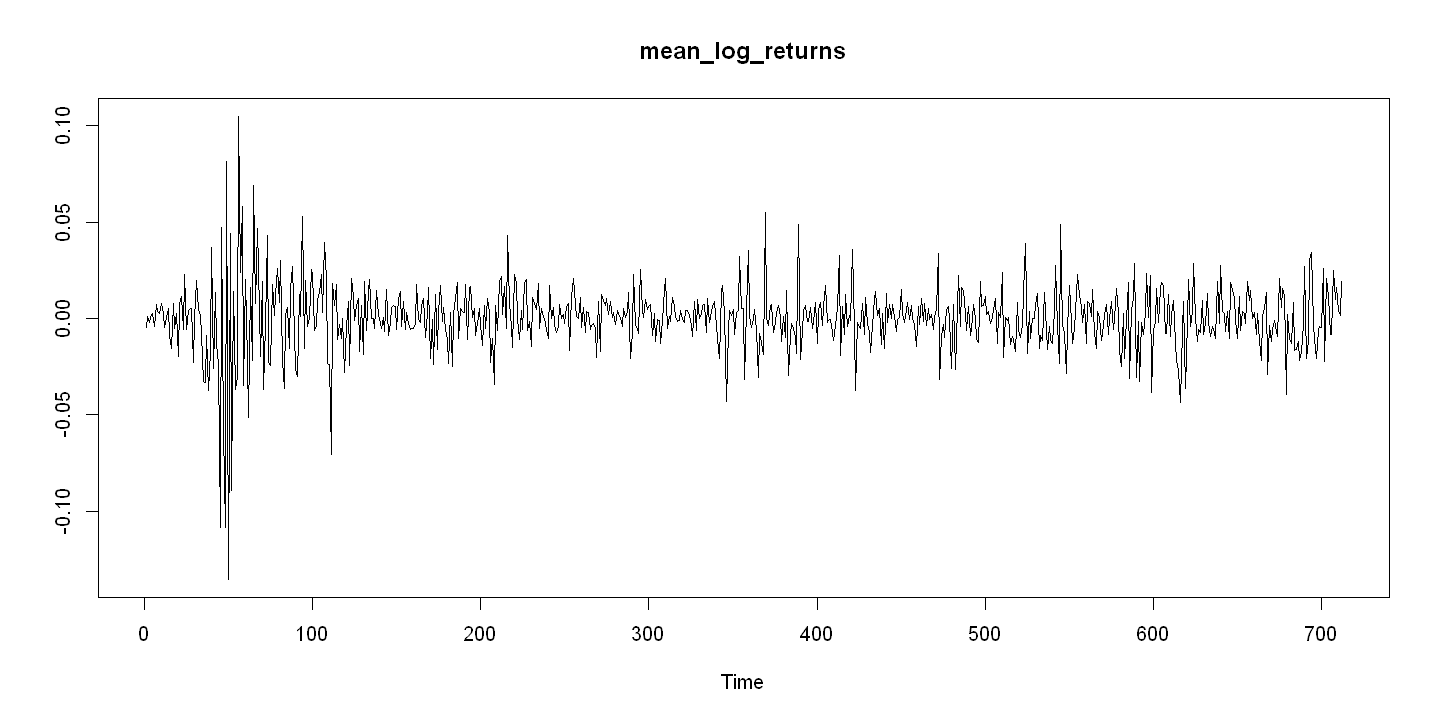

In [53]:
plot.ts(clean_data$MeanLogReturn, ylab = NA, main = 'mean_log_returns')

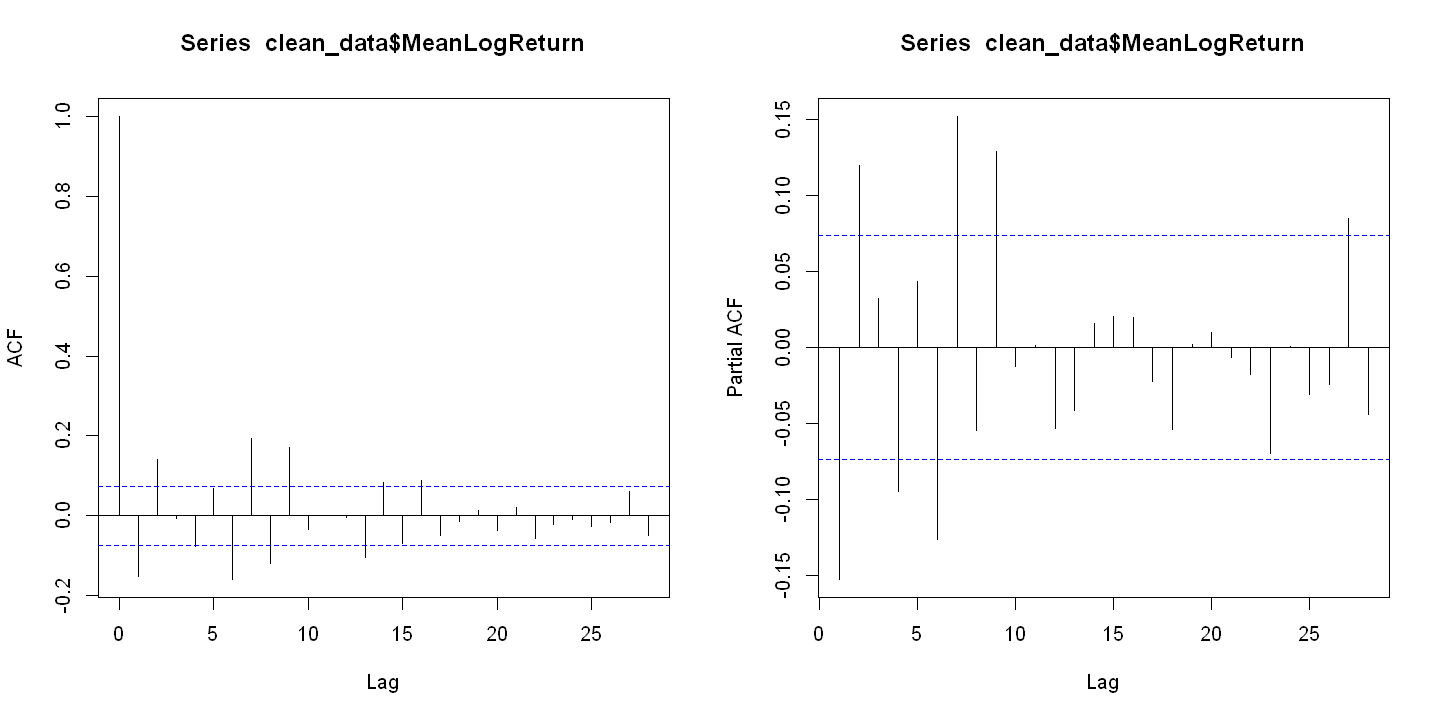

In [57]:

options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
# Setting up the plotting area
# Save default graphical parameters at the start of your notebook
#default_par <- par()

# (In another cell) After making changes and plotting
# Reset graphical parameters to defaults
#par(default_par)



# Autocorrelation and Partial Autocorrelation functions
acf(clean_data$MeanLogReturn)
pacf(clean_data$MeanLogReturn)

#print(clean_data)

rets = clean_data$MeanLogReturn

In [66]:
#install.packages('tseries')

In [65]:
library(tseries)

Box.test(rets, type = 'Ljung-Box')

adf.test(rets, k = 1)

kpss.test(rets, null = 'Level')
kpss.test(rets, null = 'Trend')


	Box-Ljung test

data:  rets
X-squared = 16.618, df = 1, p-value = 4.572e-05


Warning message in adf.test(rets, k = 1):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  rets
Dickey-Fuller = -17.867, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(rets, null = "Level"):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  rets
KPSS Level = 0.085825, Truncation lag parameter = 6, p-value = 0.1


Warning message in kpss.test(rets, null = "Trend"):
"p-value greater than printed p-value"


	KPSS Test for Trend Stationarity

data:  rets
KPSS Trend = 0.088488, Truncation lag parameter = 6, p-value = 0.1


The Ljung-Box Q test rejects the hypothesis of no autocorrelation, however the individual deviatons are on the edge of statistical significance. <- WHAT?

Based on the ADF test, we reject the null hypothesis of unit root, based on the KPSS test, we do not reject the null hypothesis of neither level or trend stationarity. On 5% sign. level.

-> based on the PACF we estimate AR(2), AR(4), and AR(6) based on the significant lags 

maybe AR(9) too...

Series: rets 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1     ar2   mean
      -0.1342  0.1195  1e-04
s.e.   0.0372  0.0372  7e-04

sigma^2 estimated as 0.0003178:  log likelihood=1858.47
AIC=-3708.93   AICc=-3708.88   BIC=-3690.66

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -2.070596e-06 0.0177889 0.0118035 111.1809 152.3467 0.6677799
                    ACF1
Training set -0.00410459


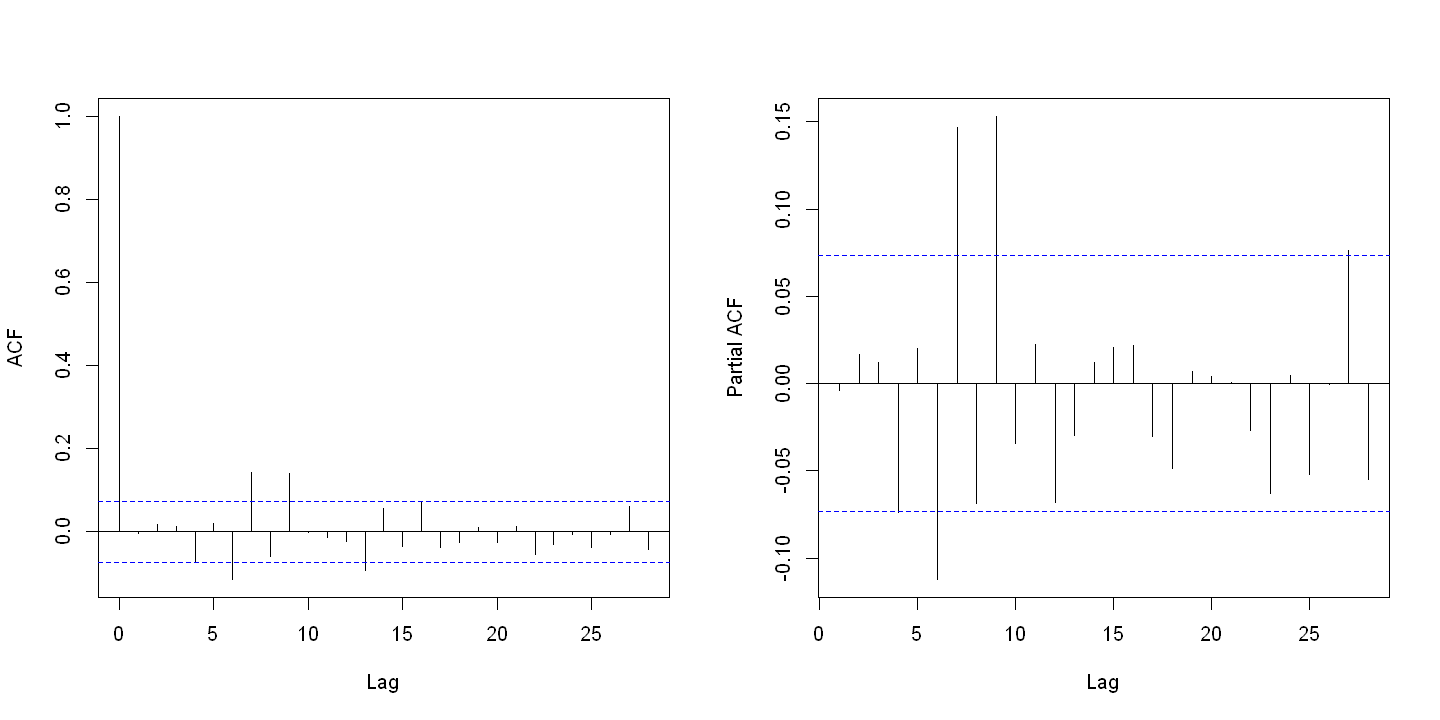

In [78]:
library(forecast)
rets_ar2 <- Arima(rets, order = c(2, 0, 0))
summary (rets_ar2)

par(mfrow = c(1, 2))
acf(rets_ar2$residuals, main = NA)
pacf(rets_ar2$residuals, main = NA)

In [79]:
Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 1)
Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 8)
Box.test(rets_ar2$residuals, type = "Ljung-Box", lag = 12)


	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 0.012046, df = 1, p-value = 0.9126



	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 31.275, df = 8, p-value = 0.0001255



	Box-Ljung test

data:  rets_ar2$residuals
X-squared = 45.93, df = 12, p-value = 7.134e-06


Series: rets 
ARIMA(9,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ar5      ar6     ar7      ar8
      -0.0909  0.0948  0.0394  -0.0790  0.0196  -0.1037  0.1309  -0.0414
s.e.   0.0372  0.0373  0.0371   0.0369  0.0370   0.0369  0.0371   0.0372
         ar9   mean
      0.1280  2e-04
s.e.  0.0371  7e-04

sigma^2 estimated as 0.0002988:  log likelihood=1883.7
AIC=-3745.39   AICc=-3745.01   BIC=-3695.14

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 3.266408e-06 0.01716385 0.01176954 88.66772 190.9661 0.6658586
                    ACF1
Training set 0.001528027


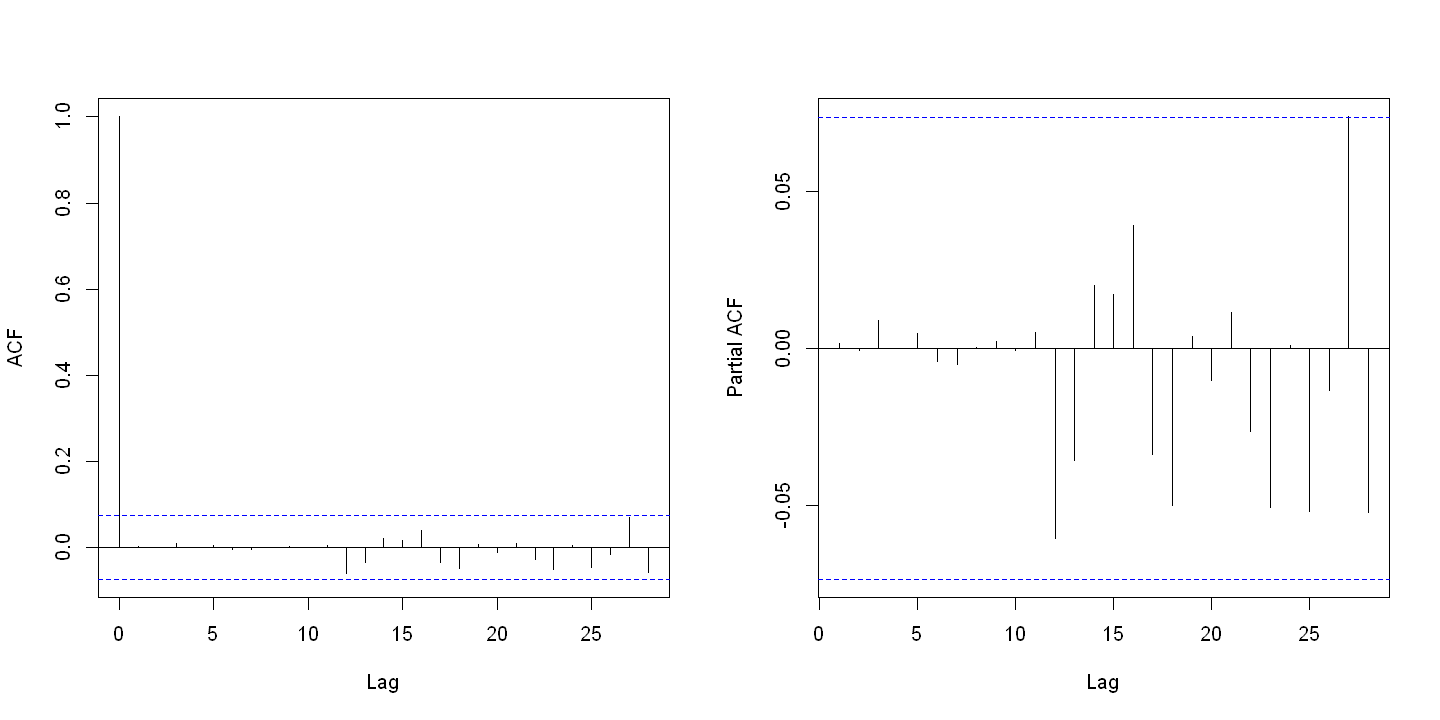

In [80]:
library(forecast)
rets_ar9 <- Arima(rets, order = c(9, 0, 0))
summary (rets_ar9)

par(mfrow = c(1, 2))
acf(rets_ar9$residuals, main = NA)
pacf(rets_ar9$residuals, main = NA)

-> ar(9) works quite well...

Also from the ACF we suspect MA(1) process...

Series: rets 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1   mean
      -0.1214  1e-04
s.e.   0.0330  6e-04

sigma^2 estimated as 0.0003235:  log likelihood=1851.6
AIC=-3697.2   AICc=-3697.17   BIC=-3683.5

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.739631e-06 0.01796173 0.01181228 113.8601 128.9496 0.6682766
                    ACF1
Training set -0.01699059



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 17.842, df = 4, p-value = 0.001325



	Box-Ljung test

data:  rets_ma1$residuals
X-squared = 57.382, df = 8, p-value = 1.517e-09


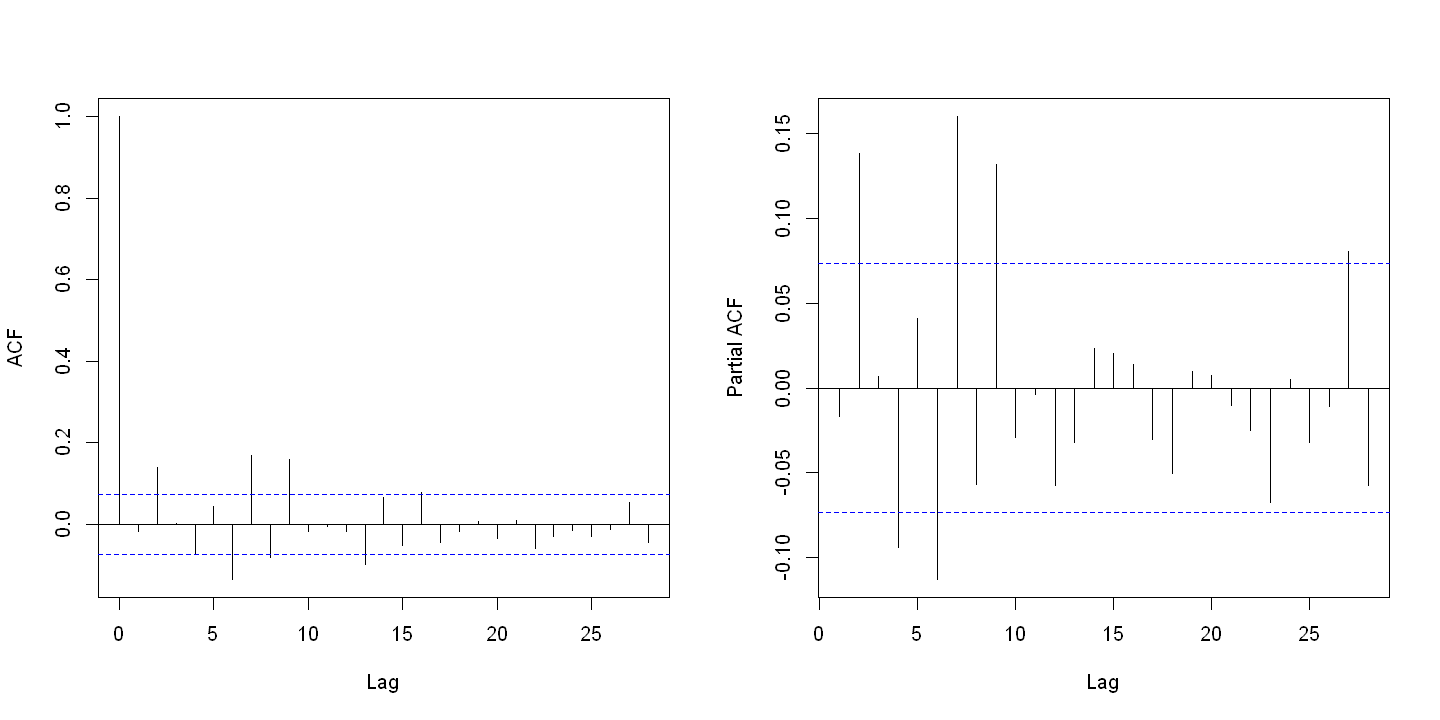

In [93]:
library(forecast)
rets_ma1 <- Arima(rets, order = c(0, 0, 1))
summary (rets_ma1)

par(mfrow = c(1, 2))
acf(rets_ma1$residuals, main = NA)
pacf(rets_ma1$residuals, main = NA)

Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ma1$residuals, type = "Ljung-Box", lag = 8)

In [94]:
auto.arima(rets)

Series: rets 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1317  0.1559
s.e.   0.0368  0.0382

sigma^2 estimated as 0.0003165:  log likelihood=1859.42
AIC=-3712.85   AICc=-3712.81   BIC=-3699.14

Series: rets 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.1317  0.1559
s.e.   0.0368  0.0382

sigma^2 estimated as 0.0003165:  log likelihood=1859.42
AIC=-3712.85   AICc=-3712.81   BIC=-3699.14

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0001424417 0.01776486 0.01185128 108.5301 159.3978 0.6704833
                     ACF1
Training set -0.003817845



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 2.7541, df = 4, p-value = 0.5998



	Box-Ljung test

data:  rets_ma2$residuals
X-squared = 30.312, df = 8, p-value = 0.0001861


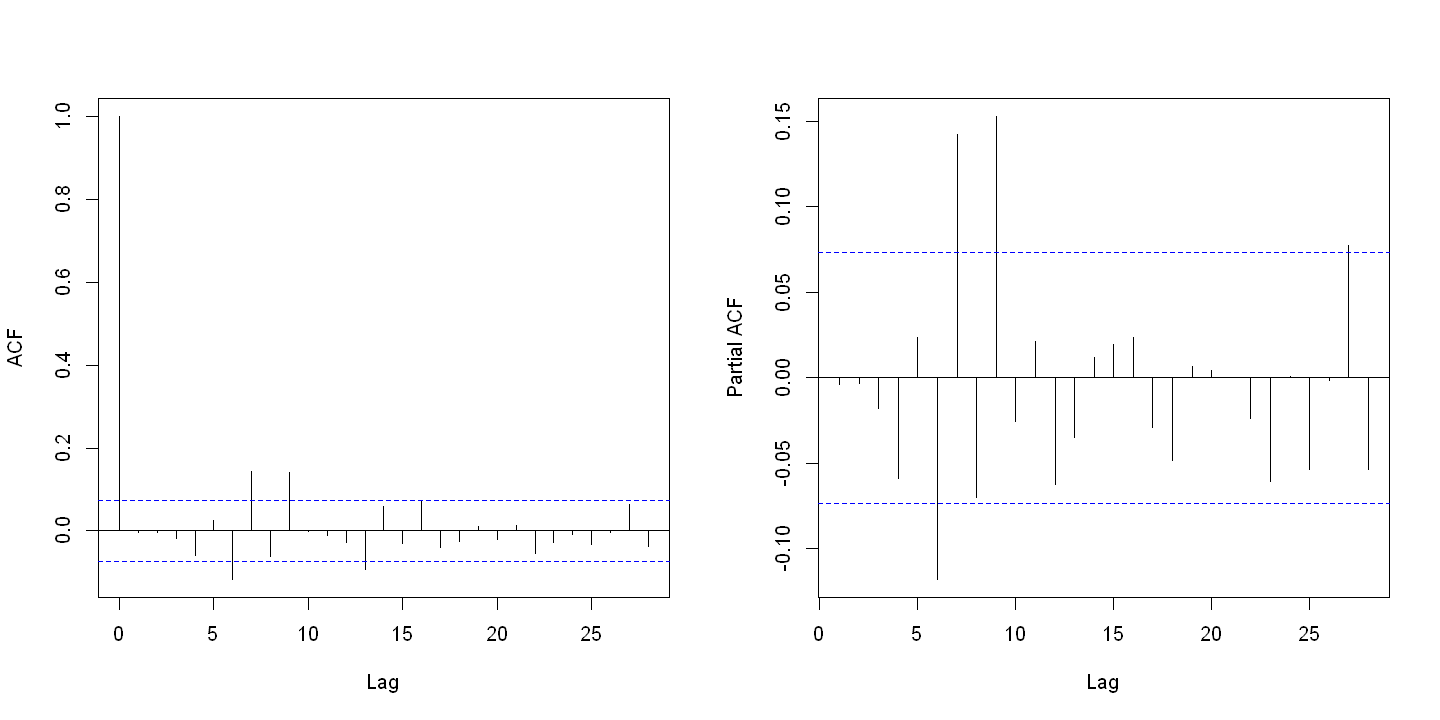

In [95]:
library(forecast)
rets_ma2 <- Arima(rets, order = c(0, 0, 2), include.mean = FALSE)
summary (rets_ma2)

par(mfrow = c(1, 2))
acf(rets_ma2$residuals, main = NA)
pacf(rets_ma2$residuals, main = NA)


Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_ma2$residuals, type = "Ljung-Box", lag = 8)

Series: rets 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ar3     ar4     ma1     ma2   mean
      -1.6484  -0.7093  0.1152  0.0345  1.5657  0.6722  1e-04
s.e.   0.1307   0.1414  0.0759  0.0561  0.1245  0.1099  7e-04

sigma^2 estimated as 0.0003015:  log likelihood=1879.01
AIC=-3742.03   AICc=-3741.82   BIC=-3705.48

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 6.192295e-07 0.01727824 0.01177362 97.09089 187.8725 0.6660895
                      ACF1
Training set -0.0004020231



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 0.46808, df = 4, p-value = 0.9765



	Box-Ljung test

data:  rets_arma42$residuals
X-squared = 5.2949, df = 8, p-value = 0.7256


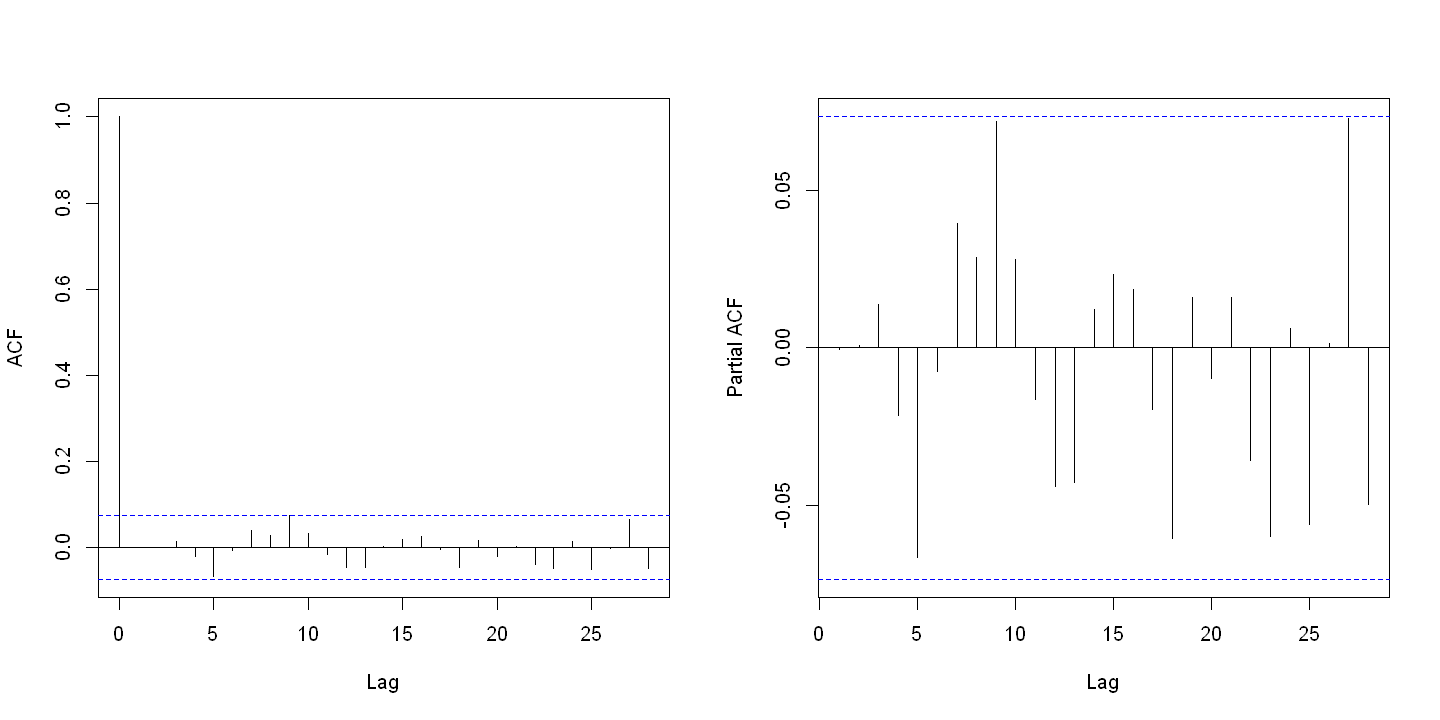

In [105]:
 library(forecast)
rets_arma42 <- Arima(rets, order = c(4, 0, 2))
summary (rets_arma42)

par(mfrow = c(1, 2))
acf(rets_arma42$residuals, main = NA)
pacf(rets_arma42$residuals, main = NA)


Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 4)
Box.test(rets_arma42$residuals, type = "Ljung-Box", lag = 8)

-> seems to be the best model based on the acf, pacf, as well as the tests. acf as well as pacf have no significant lags.

----------------------------------------------------------------------------------
# HERE ADD AIC AND BIC CRITERIA!!

In [107]:
models <- 5
criteria <- matrix(ncol = 2, nrow = models)
colnames(criteria) <- c('AIC', 'BIC')
rownames(criteria) <- c('AR(2)', 'AR(9)','ARMA(4,2)','MA(1)','MA(2)')

criteria[1, 1] <- rets_ar2$aic
criteria[1, 2] <- rets_ar2$bic
criteria[2, 1] <- rets_ar9$aic
criteria[2, 2] <- rets_ar9$bic

criteria[3, 1] <- rets_arma42$aic
criteria[3, 2] <- rets_arma42$bic
criteria[4, 1] <- rets_ma1$aic
criteria[4, 2] <- rets_ma1$bic
criteria[5, 1] <- rets_ma2$aic
criteria[5, 2] <- rets_ma2$bic

criteria

,AIC,BIC
AR(2),-3708.933,-3690.660
AR(9),-3745.391,-3695.142
"ARMA(4,2)",-3742.028,-3705.483
MA(1),-3697.202,-3683.497
MA(2),-3712.848,-3699.144


-> based on those criteria we would choose ma(1) since it has both criteria the lowest...

...but what about the tests??

!! but its in minus so!!  --> we would choose arma(4,2)!!